In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, f1_score
import warnings
warnings.filterwarnings('ignore')
import os

os.makedirs('outputs/figures', exist_ok=True)
os.makedirs('outputs/results', exist_ok=True)
os.makedirs('outputs/gridsearch', exist_ok=True)

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully


## 1. Load and Preprocess Data

In [2]:
# Load energy efficiency data
df = pd.read_excel('energy_efficiency/ENB2012_data.xlsx')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nHeating Load statistics:")
print(df['Y1'].describe())

# Convert regression to binary classification using median split
median_heating = df['Y1'].median()
df['Heating_Class'] = (df['Y1'] > median_heating).astype(int)

print(f"\nMedian Heating Load: {median_heating:.2f}")
print(f"\nBinary Class Distribution:")
print(df['Heating_Class'].value_counts())

# Features and target
X = df.drop(['Y1', 'Y2', 'Heating_Class'], axis=1)
y = df['Heating_Class']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\n✓ Data preprocessed")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Class distribution - Train: {np.bincount(y_train)}")
print(f"Class distribution - Test: {np.bincount(y_test)}")

Dataset shape: (768, 10)

Columns: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'Y1', 'Y2']

Heating Load statistics:
count    768.000000
mean      22.307195
std       10.090204
min        6.010000
25%       12.992500
50%       18.950000
75%       31.667500
max       43.100000
Name: Y1, dtype: float64

Median Heating Load: 18.95

Binary Class Distribution:
Heating_Class
0    384
1    384
Name: count, dtype: int64

✓ Data preprocessed
Training set: (537, 8)
Test set: (231, 8)
Class distribution - Train: [268 269]
Class distribution - Test: [116 115]


## 2. Define Hyperparameter Grids

In [3]:
param_grids = {
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11, 15, 21],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'Logistic Regression': {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [1000]
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'poly'],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]
    },
    'MLP': {
        'hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100), (150, 100, 50)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [500]
    },
    'Decision Tree': {
        'max_depth': [3, 5, 7, 10, 15, 20, None],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 2, 4, 8],
        'criterion': ['gini', 'entropy']
    },
    'Naive Bayes': {
        'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
    }
}

classifiers = {
    'KNN': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(random_state=42),
    'SVM': SVC(random_state=42),
    'MLP': MLPClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Naive Bayes': GaussianNB()
}

print("✓ Hyperparameter grids defined")

✓ Hyperparameter grids defined


## 3. Perform GridSearchCV

In [4]:
grid_results = {}
best_models = {}

print("="*80)
print("ENERGY EFFICIENCY - HYPERPARAMETER SENSITIVITY ANALYSIS")
print("="*80)

for name in classifiers.keys():
    print(f"\n{'='*80}")
    print(f"GridSearchCV: {name}")
    print(f"{'='*80}")
    
    grid_search = GridSearchCV(
        classifiers[name], 
        param_grids[name], 
        cv=3, 
        scoring='accuracy',
        n_jobs=-1,
        verbose=0
    )
    
    grid_search.fit(X_train_scaled, y_train)
    
    grid_results[name] = {
        'best_params': grid_search.best_params_,
        'best_score': grid_search.best_score_,
        'cv_results': grid_search.cv_results_,
        'all_scores': grid_search.cv_results_['mean_test_score'],
        'std_scores': grid_search.cv_results_['std_test_score']
    }
    best_models[name] = grid_search.best_estimator_
    
    y_pred = grid_search.best_estimator_.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred)
    
    score_variance = np.var(grid_search.cv_results_['mean_test_score'])
    score_std = np.std(grid_search.cv_results_['mean_test_score'])
    score_range = np.max(grid_search.cv_results_['mean_test_score']) - np.min(grid_search.cv_results_['mean_test_score'])
    
    grid_results[name]['test_accuracy'] = test_accuracy
    grid_results[name]['test_f1'] = test_f1
    grid_results[name]['variance'] = score_variance
    grid_results[name]['std'] = score_std
    grid_results[name]['range'] = score_range
    
    print(f"Best CV Score: {grid_search.best_score_:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Sensitivity - Variance: {score_variance:.6f}, Range: {score_range:.4f}")

print("\n✓ GridSearchCV completed")

ENERGY EFFICIENCY - HYPERPARAMETER SENSITIVITY ANALYSIS

GridSearchCV: KNN
Best CV Score: 0.9851
Test Accuracy: 0.9697
Sensitivity - Variance: 0.000002, Range: 0.0074

GridSearchCV: Logistic Regression
Best CV Score: 0.9851
Test Accuracy: 0.9697
Sensitivity - Variance: 0.000002, Range: 0.0074

GridSearchCV: Logistic Regression
Best CV Score: 0.9814
Test Accuracy: 0.9654
Sensitivity - Variance: 0.017534, Range: 0.4823

GridSearchCV: SVM
Best CV Score: 0.9814
Test Accuracy: 0.9740
Sensitivity - Variance: 0.007132, Range: 0.2756

GridSearchCV: MLP
Best CV Score: 0.9814
Test Accuracy: 0.9654
Sensitivity - Variance: 0.017534, Range: 0.4823

GridSearchCV: SVM
Best CV Score: 0.9814
Test Accuracy: 0.9740
Sensitivity - Variance: 0.007132, Range: 0.2756

GridSearchCV: MLP
Best CV Score: 0.9777
Test Accuracy: 0.9697
Sensitivity - Variance: 0.000004, Range: 0.0056

GridSearchCV: Decision Tree
Best CV Score: 0.9777
Test Accuracy: 0.9697
Sensitivity - Variance: 0.000004, Range: 0.0056

GridSearchCV:

## 4. Sensitivity Summary & Visualizations


HYPERPARAMETER SENSITIVITY RANKING - ENERGY EFFICIENCY
         Classifier  Best CV Score  Test Accuracy  Test F1  Variance  Std Dev  Range
Logistic Regression         0.9814         0.9654   0.9646    0.0175   0.1324 0.4823
                SVM         0.9814         0.9740   0.9737    0.0071   0.0845 0.2756
                KNN         0.9851         0.9697   0.9694    0.0000   0.0015 0.0074
                MLP         0.9777         0.9697   0.9692    0.0000   0.0021 0.0056
      Decision Tree         0.9870         0.9784   0.9784    0.0000   0.0031 0.0112
        Naive Bayes         0.9795         0.9697   0.9694    0.0000   0.0000 0.0000


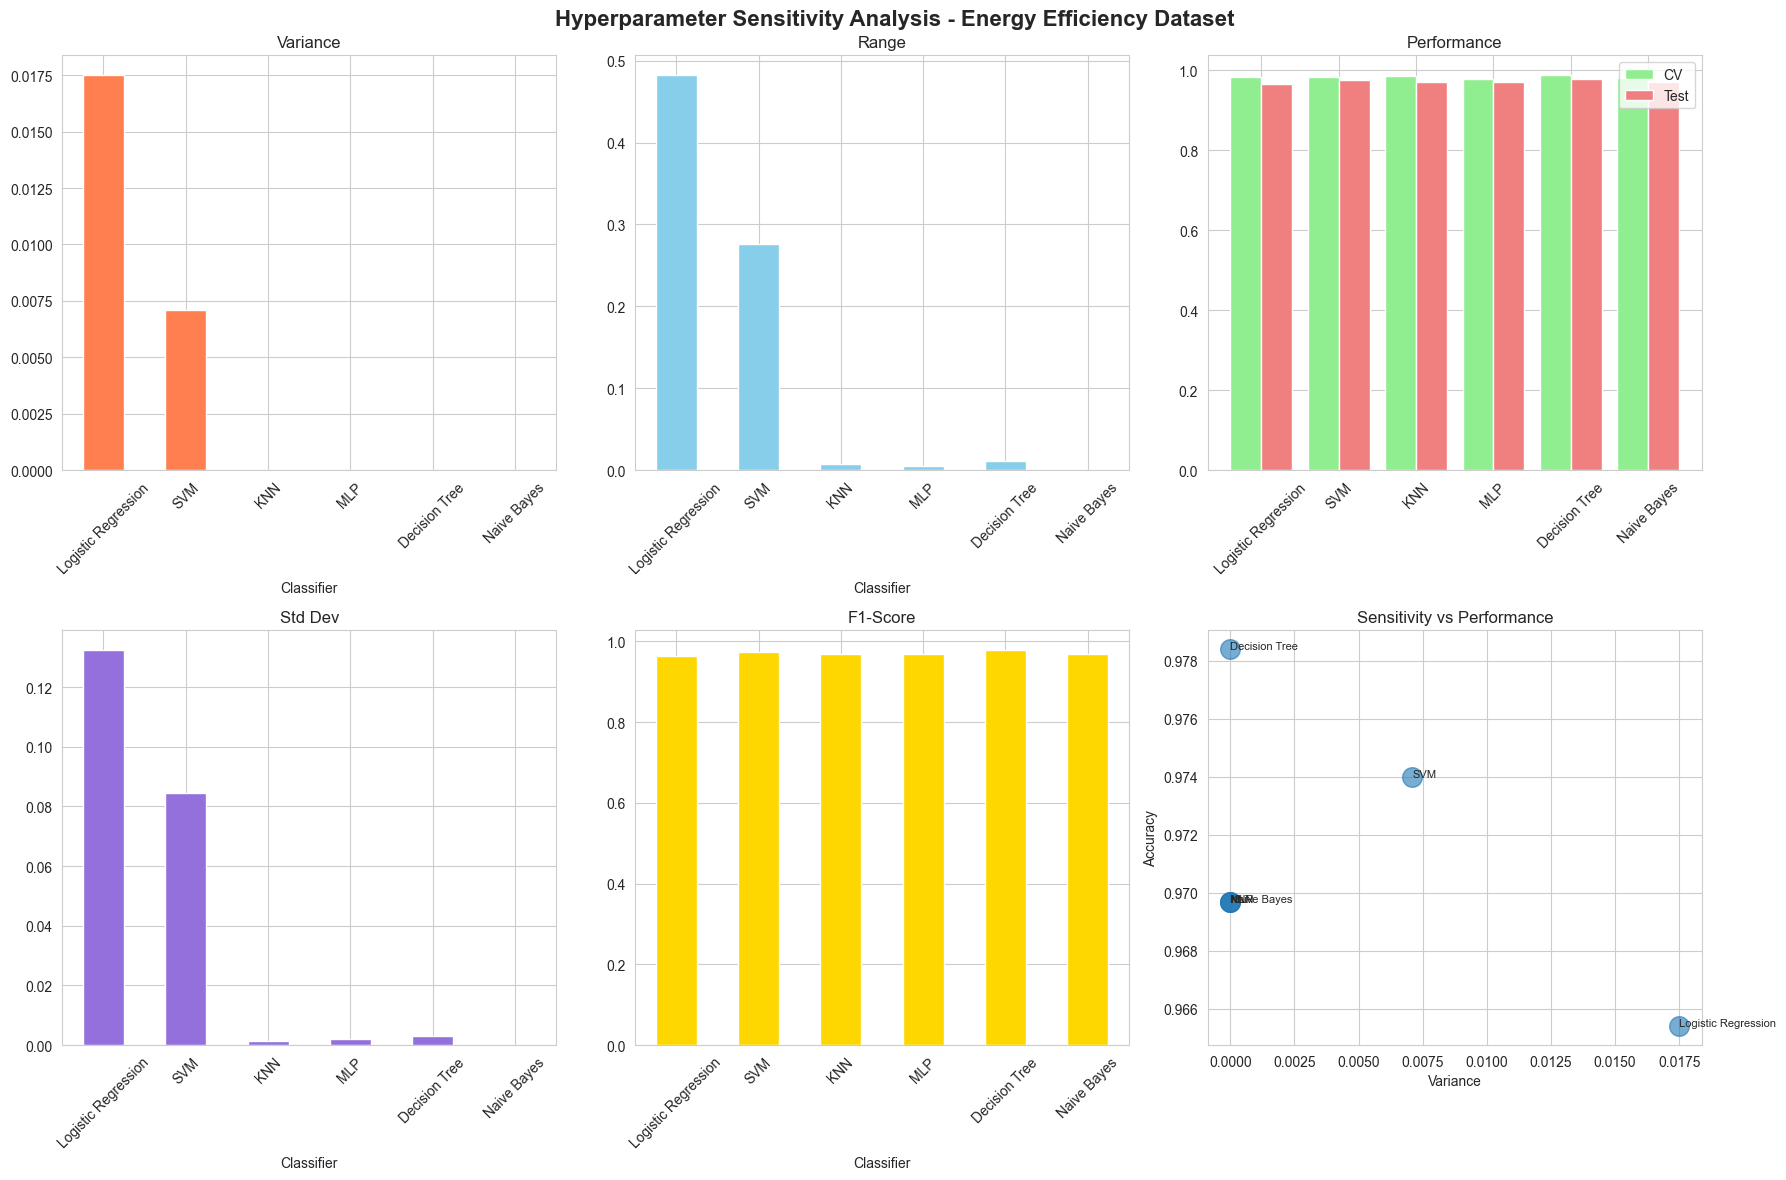


✓ Analysis complete


In [5]:
sensitivity_summary = pd.DataFrame({
    'Classifier': list(grid_results.keys()),
    'Best CV Score': [grid_results[name]['best_score'] for name in grid_results.keys()],
    'Test Accuracy': [grid_results[name]['test_accuracy'] for name in grid_results.keys()],
    'Test F1': [grid_results[name]['test_f1'] for name in grid_results.keys()],
    'Variance': [grid_results[name]['variance'] for name in grid_results.keys()],
    'Std Dev': [grid_results[name]['std'] for name in grid_results.keys()],
    'Range': [grid_results[name]['range'] for name in grid_results.keys()]
}).round(4).sort_values('Variance', ascending=False)

print("\nHYPERPARAMETER SENSITIVITY RANKING - ENERGY EFFICIENCY")
print("="*80)
print(sensitivity_summary.to_string(index=False))

sensitivity_summary.to_csv('outputs/results/energy_sensitivity.csv', index=False)

# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Hyperparameter Sensitivity Analysis - Energy Efficiency Dataset', fontsize=16, fontweight='bold')

sensitivity_summary.plot(x='Classifier', y='Variance', kind='bar', ax=axes[0,0], color='coral', legend=False)
axes[0,0].set_title('Variance')
axes[0,0].tick_params(axis='x', rotation=45)

sensitivity_summary.plot(x='Classifier', y='Range', kind='bar', ax=axes[0,1], color='skyblue', legend=False)
axes[0,1].set_title('Range')
axes[0,1].tick_params(axis='x', rotation=45)

x_pos = np.arange(len(sensitivity_summary))
axes[0,2].bar(x_pos - 0.2, sensitivity_summary['Best CV Score'], 0.4, label='CV', color='lightgreen')
axes[0,2].bar(x_pos + 0.2, sensitivity_summary['Test Accuracy'], 0.4, label='Test', color='lightcoral')
axes[0,2].set_xticks(x_pos)
axes[0,2].set_xticklabels(sensitivity_summary['Classifier'], rotation=45)
axes[0,2].set_title('Performance')
axes[0,2].legend()

sensitivity_summary.plot(x='Classifier', y='Std Dev', kind='bar', ax=axes[1,0], color='mediumpurple', legend=False)
axes[1,0].set_title('Std Dev')
axes[1,0].tick_params(axis='x', rotation=45)

sensitivity_summary.plot(x='Classifier', y='Test F1', kind='bar', ax=axes[1,1], color='gold', legend=False)
axes[1,1].set_title('F1-Score')
axes[1,1].tick_params(axis='x', rotation=45)

axes[1,2].scatter(sensitivity_summary['Variance'], sensitivity_summary['Test Accuracy'], s=200, alpha=0.6)
for idx, row in sensitivity_summary.iterrows():
    axes[1,2].annotate(row['Classifier'], (row['Variance'], row['Test Accuracy']), fontsize=8)
axes[1,2].set_title('Sensitivity vs Performance')
axes[1,2].set_xlabel('Variance')
axes[1,2].set_ylabel('Accuracy')

plt.tight_layout()
plt.savefig('outputs/figures/energy_sensitivity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Analysis complete")

## 5. Save Detailed GridSearch Results

In [6]:
for name in grid_results.keys():
    cv_results = grid_results[name]['cv_results']
    results_df = pd.DataFrame(cv_results)
    results_df.to_csv(f'outputs/gridsearch/energy_{name.replace(" ", "_").lower()}_gridsearch.csv', index=False)

print("✓ Detailed GridSearch results saved to outputs/gridsearch/")
print("\n" + "="*80)
print("✓ Analysis complete for Energy Efficiency dataset")
print("="*80)

✓ Detailed GridSearch results saved to outputs/gridsearch/

✓ Analysis complete for Energy Efficiency dataset
